# Project 1 - Classifying Vehicles On The Road
A simple project to explore how to use fast AI in classifying images of vehicles on the road, specifically bicycles, cars, trucks.

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

## Get The data

In [3]:
import os
# azure key for Bing Image Search
key = os.environ.get('AZURE_SERACH_KEY', 'key_here')

In [4]:
# check function
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
# image classes
classes = 'bicylce', 'car', 'truck'
# initialise path
path = Path('data/vehicles')

In [6]:
# define function to download the data
def get_data(path):
    """
        Get Data from seraching bing and store into the path supplied
    """
    # create a new directory using the path supplied
    path.mkdir(parents=True, exist_ok=True)
    
    # loop through classes and search
    for c in classes:
        # destination -- e.g path/car
        dest = (path/c)
        # create folder
        dest.mkdir(exist_ok = True)
        # search bing
        results = search_images_bing(key, f'{c}')
        # download images
        download_images(dest, urls=results.attrgot('contentUrl'))
    

In [7]:
# call function to get data
get_data(path)

In [8]:
# check the image filenames
fn = get_image_files(path)
fn

(#425) [Path('data/vehicles/car/00000043.jpg'),Path('data/vehicles/car/00000128.jpg'),Path('data/vehicles/car/00000119.jpg'),Path('data/vehicles/car/00000104.jpg'),Path('data/vehicles/car/00000020.jpg'),Path('data/vehicles/car/00000032.jpg'),Path('data/vehicles/car/00000037.jpg'),Path('data/vehicles/car/00000089.jpg'),Path('data/vehicles/car/00000099.jpg'),Path('data/vehicles/car/00000145.jpg')...]

In [9]:
# check for failed downloads
fail = verify_images(fn)
fail

(#0) []

In [10]:
# remove failed images
fail.map(Path.unlink)

(#0) []

## Data Preparation

In [11]:
# create a data block
vehicles = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    # how to split the validation set
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    # augment each image - create 256px images allow for at least 50%
    item_tfms = RandomResizedCrop(256, min_scale=0.5),
    # batch augmentation
    batch_tfms = aug_transforms(mult=2)
)

In [12]:
# create data loaders
dls = vehicles.dataloaders(path)

/srv/conda/envs/notebook/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


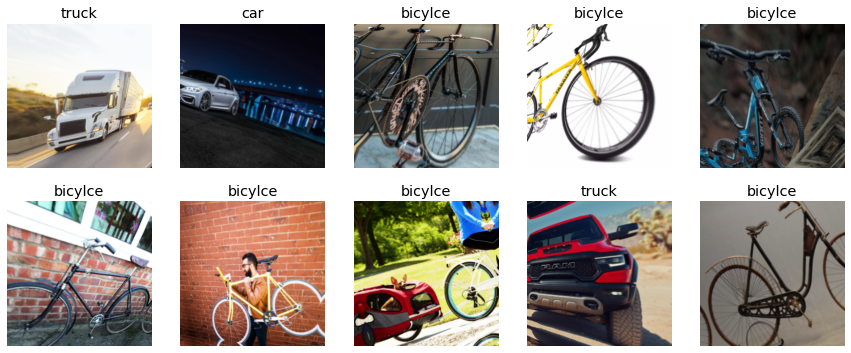

In [13]:
# show some training images
dls.train.show_batch(nrows = 2, max_n = 10)

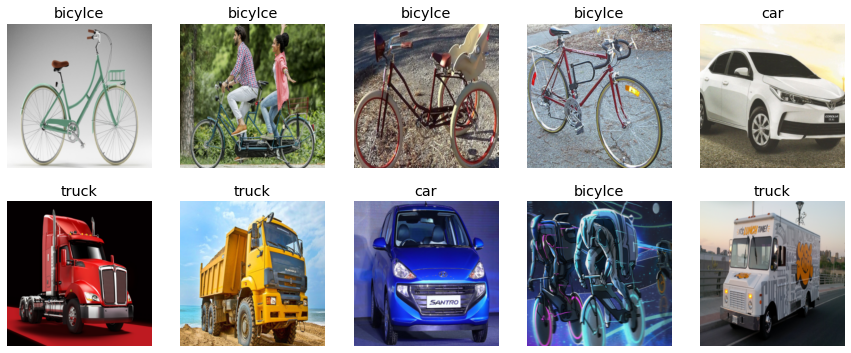

In [14]:
# show some validation images
dls.valid.show_batch(nrows = 2, max_n = 10)

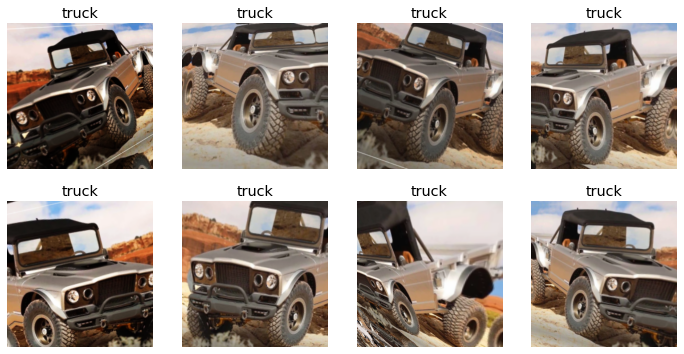

In [15]:
# show how train was augmented
dls.train.show_batch(nrows = 2, max_n = 8, unique=True)

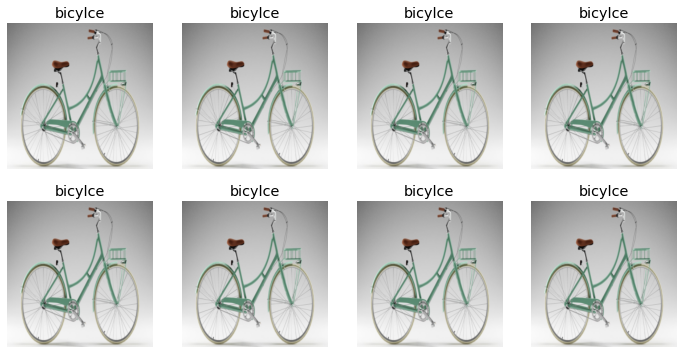

In [16]:
# show how valid was augmented
dls.valid.show_batch(nrows = 2, max_n = 8, unique=True)

## Create and Train a Model

In [17]:
# define the model
model = cnn_learner(
    dls = dls,
    # probably overkill
    arch = densenet121,
    metrics = [error_rate, accuracy]
)

/srv/conda/envs/notebook/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [18]:
# train the model for 5 epochs
# model.fine_tune(5)

In [ ]:
# actual training occured elsewhere, load the model 
model = load_model('vehicles_model')